In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy.table import Table
from astropy.constants import R_sun, R_earth

In [160]:
from keras.models import load_model

filepath = 'data/model.hdf5'
model = load_model(filepath)

In [153]:
koi_table['kepid'].data.data

array([b'10797460', b'10797460', b'10811496', ..., b'10147276',
       b'10155286', b'10156110'], dtype=object)

In [267]:
archive = h5py.File('../data/kepler_lcs/archive.hdf5', 'r')

kepid = '010748390'

times, fluxes = archive[kepid]

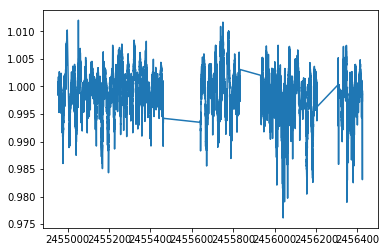

In [268]:
plt.plot(times, fluxes)

In [273]:
from scipy.stats import binned_statistic
bin_edges = np.linspace(-0.5, 0.5, 51)

In [362]:
from astropy.time import Time
import sys
sys.path.insert(0, '../../TESSellate/')
from toolkit import LightCurve

bstr = str(int(kepid)).encode()
props = koi_table.loc[bstr]

if not isinstance(koi_table.loc[bstr]['kepid'], bytes): 
    props = props[np.argmax(props['koi_depth'])]

period = props['koi_period']
duration = props['koi_duration'] / 24

epoch = props['koi_time0bk'] + 2454833 #+ 0.5*duration
b = props['koi_impact']

params = TransitParams()
params.per = period
params.t0 = epoch
params.duration = duration
params.rp = float(props['koi_prad']*R_earth/(props['koi_srad']*R_sun)) #(props['koi_depth'] * 1e-6)**0.5

a = (np.sin(duration * np.pi / period) / np.sqrt((1 + params.rp)**2 - b**2))**-1

params.a = a
params.inc = np.degrees(np.arccos(b / params.a))
params.w = 90
params.ecc = 0
params.limb_dark = 'quadratic'
params.u = [0.5079, 0.2239]

t, f = archive[kepid][:]
sort = np.argsort(t)

t = Time(t[sort], format='jd')
f = f[sort]

lc = LightCurve(t, f)
packed = lc.mask_out_of_transit(params, oot_duration_fraction=1.5)
transits = []
transits = LightCurve(**packed).get_transit_light_curves(params)

rescaled_lcs = []
mean_times = []
for i, transit in enumerate(transits): 
    transit.remove_polynomial_baseline(params, order=2)
    mean_times.append(transit.times.jd.mean())
    midtransittime = round((transit.times.jd.mean() - params.t0) / params.per)

    rescaled_times = (transit.times.jd - (params.t0 + midtransittime*params.per)) / duration
    
    bs = binned_statistic(rescaled_times, transit.fluxes, bins=bin_edges, statistic='median')
    
    rescaled_lc = bs.statistic - bs.statistic.mean()
    rescaled_lc /= rescaled_lc.ptp()
    
    rescaled_lcs.append(rescaled_lc)

    predict_y = model.predict(rescaled_lc[np.newaxis, :, np.newaxis])
#     plt.title('Spotted' if np.argmax(predict_y, axis=1) == 1 else 'Not spotted' + str(i))
#     plt.scatter(bin_edges[:-1], rescaled_lc, marker='o')
#     plt.show()
    
#     transit.plot()

In [303]:
>>> trick = np.r_[0:3,5:10]
>>> np.arange(10)[trick]
# array([0, 1, 2, 5, 6, 7, 8, 9])

array([0, 1, 2, 5, 6, 7, 8, 9])

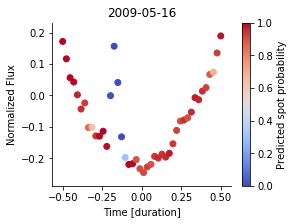

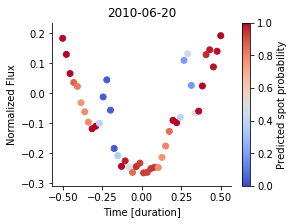

In [451]:
# plt.plot(rescaled_lcs[34])
colors = []
window = 6
x = np.arange(50)
transit_numbers = [2, 78] # 2 # 40 # 78 # 22

for transit_number in transit_numbers:
    x_interps = []
    y_not_interps = []
    pred_ys = []

    for i in range(window//2, 50-window//2):
        sliced = np.r_[0:i-window//2,i+window//2:50]
    #     plt.scatter(x[sliced], rescaled_lcs[34][sliced])
        y_interped = np.interp(x, x[sliced], rescaled_lcs[transit_number][sliced])
    #     plt.plot(x, y_interped)

        pred_y = model.predict(y_interped[np.newaxis, :, np.newaxis])
    #     print(pred_y)
    #     cax = plt.scatter(x[i], rescaled_lcs[2][i], c=[plt.cm.coolwarm(pred_y[0, 1])])
        x_interps.append(x[i])
        y_not_interps.append(rescaled_lcs[transit_number][i])
        pred_ys.append(pred_y[0, 1])

    fig, ax = plt.subplots(figsize=(4, 3))
    cax = plt.scatter(np.linspace(-0.5, 0.5, 50-window), y_not_interps, c=pred_ys, 
                      cmap=plt.cm.coolwarm, vmin=0, vmax=1)
    cbar = plt.colorbar(cax)

    predict_y = model.predict(rescaled_lcs[transit_number][np.newaxis, :, np.newaxis])
    # plt.title('Spotted' if np.argmax(predict_y, axis=1) == 1 else 'Not spotted')
    ax.set_xlabel('Time [duration]')
    ax.set_ylabel('Normalized Flux')
    cbar.set_label('Predicted spot probability')
    ax.set_title(Time(mean_times[transit_number], format='jd').datetime.date())
    for s in ['right', 'top']:
        ax.spines[s].set_visible(False)
    fig.savefig('plots/spotted_probability_{0}.pdf'.format(transit_number), bbox_inches='tight')
    plt.savefig('plots/spotted_probability_{0}.png'.format(transit_number), bbox_inches='tight', dpi=200)
    plt.show()

In [365]:
print(Time(mean_times[transit_number], format='jd').iso)

2009-05-16 02:11:48.721


In [154]:
# import astropy.units as u
# from fleck import generate_spots, Star
# from batman import TransitParams
# import sys
# sys.path.insert(0, '../')
# from sun import draw_random_sunspot_latitudes, draw_random_sunspot_radii

# archive = h5py.File('../data/kepler_lcs/archive.hdf5', 'r')

# keys = list(archive)

# koi_table = Table.read('../data/cumulative_2019.07.05_01.52.59.votable')
# koi_table.add_index('kepid')

# n_spots = 28 

# inc_stellar = 90 * u.deg

# spot_contrast = 0.7
# u_ld = [0.5079, 0.2239]
# koi_stdevs = np.load('../data/oot_scatter.npy')

# times = np.linspace(planet.t0-0.1, planet.t0+0.1, 300)

# star = Star(spot_contrast=spot_contrast, u_ld=u_ld, rotation_period=26)

# n_iterations = 1

# residual_ptp = []


# # Draw spot latitude and radius from actual sunspot distributions

# lcs = []
# truth = []
# for i in range(50): 
#     if i % 2 == 0: 
#         oddeven = [0]
#     else: 
#         oddeven = np.arange(n_spots)

#     kepid = keys[np.random.randint(0, len(keys))]

#     bstr = str(int(kepid)).encode()

#     props = koi_table.loc[bstr]

#     if not isinstance(koi_table.loc[bstr]['kepid'], bytes): 
#         props = props[np.argmax(props['koi_depth'])]

#     period = props['koi_period']
#     duration = props['koi_duration'] / 24

#     epoch = props['koi_time0bk'] + 2454833
#     b = props['koi_impact']

#     params = TransitParams()
#     params.per = period
#     params.t0 = 0
#     params.duration = duration
#     params.rp = float(props['koi_prad']*R_earth/(props['koi_srad']*R_sun))
#     a = (np.sin(duration * np.pi / period) / np.sqrt((1 + params.rp)**2 - b**2))**-1
#     params.a = a
#     params.inc = np.degrees(np.arccos(b/params.a))
#     params.limb_dark = 'quadratic'
#     params.u = u_ld
#     params.ecc = 0
#     params.w = 90

# #     if params.rp**2 > 0.005 and stddev < params.rp**2 and duration < 0.2: 

#     stddev = koi_stdevs[np.random.randint(0, len(koi_stdevs))]

#     lons = 360 * np.random.rand(n_spots)[:, np.newaxis] * u.deg
#     lats = draw_random_sunspot_latitudes(n_spots)[:, np.newaxis] 
#     #radii = 0.02 + (0.08 - 0.02)*np.random.randn(n_spots)[:, np.newaxis] #0.04 * np.ones(n_spots)[:, np.newaxis]
#     radii = 0.1 * np.ones(n_spots)[:, np.newaxis]

#     lc, spots_occulted = star.light_curve(lons[oddeven], lats[oddeven], radii[oddeven], inc_stellar, planet=planet, 
#                                           times=times, return_spots_occulted=True, fast=True)

#     lc += koi_stdevs[np.random.randint(0, len(koi_stdevs))] * np.random.randn(len(lc))[:, np.newaxis]

#     lcs.append(lc)
#     truth.append(spots_occulted)

In [162]:
# lcs = np.load('data/parallel_general/103647986_simulated_transit_lcs.npy')
# truth = np.load('data/parallel_general/103647986_simulated_spots_occulted.npy')

lcs = np.load('data/parallel_normed/015374943_simulated_transit_lcs.npy')
truth = np.load('data/parallel_normed/015374943_simulated_spots_occulted.npy')

In [163]:
# lcs = np.hstack(lcs)

In [164]:
lcs.shape

(50, 500)

True
True
True
True
True


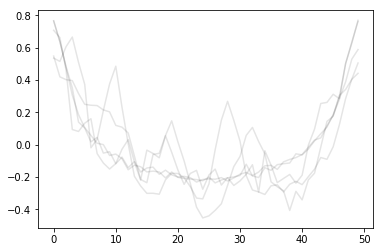

In [166]:
for i in range(5):
    plt.plot(lcs[:, i], alpha=0.1, color='k')
    print(spots_occulted)

In [196]:
from glob import glob

In [197]:
X = []
labels = []

for lcpath, truthpath in zip(sorted(glob('data/parallel_normed/*_simulated_transit_lcs.npy')), 
                             sorted(glob('data/parallel_normed/*_simulated_spots_occulted.npy'))):
    print(np.shape(np.load(lcpath).T))
    X.append(np.load(lcpath).T)
    labels.append(np.load(truthpath))

X = np.concatenate(X)[:, :, np.newaxis]# - np.array(X).mean()
X -= X.mean()
X /= X.ptp()
# X += 0.5
labels = np.hstack(labels)#[:, np.newaxis]


predict_y = model.predict(X)
correct = np.argmax(predict_y, axis=1).astype(bool) == labels
# print(np.count_nonzero(correct)/len(correct))
# print(correct)

# for i, x in enumerate(X): 
#     plt.title(str(np.argmax(predict_y, axis=1)[i]) +' '+ 
#               str(np.argmax(predict_y, axis=1)[i] == truth[i]))
#     plt.plot(x)
#     plt.show()

# X = np.random.randn(*X.shape)

(500, 50)
(1000, 50)
(500, 50)
(1000, 50)
(500, 50)
(500, 50)
(1000, 50)
(500, 50)
(1000, 50)
(1000, 50)
(1000, 50)
(500, 50)
(500, 50)
(1000, 50)
(500, 50)
(1000, 50)


In [199]:
correct.shape

(12000,)

In [211]:
print('true pos', np.count_nonzero(correct & truth)/len(correct))

print('true neg', np.count_nonzero(correct & ~truth)/len(correct))

print('false pos', np.count_nonzero(~correct & truth)/len(correct))

print('false neg', np.count_nonzero(~correct & ~truth)/len(correct))

true pos 0.40658333333333335
true neg 0.5175833333333333
false pos 0.07541666666666667
false neg 0.0004166666666666667


[ 0  1  4  6  7  8 10 11 20 22] [ 2  3  9 12 13 14 15 16 17 18] [  5  35  54  62  64  87  98 132 161 175] 2346


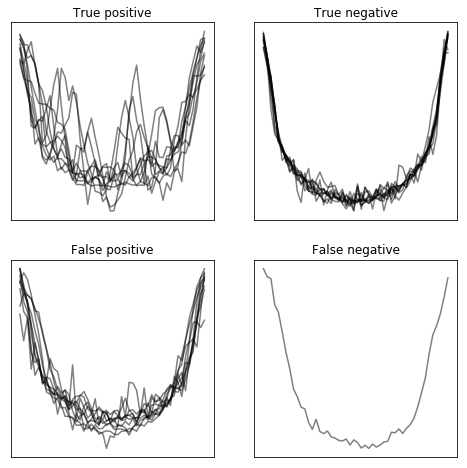

In [208]:
n_draws = 10
truth = labels

true_positive = np.argwhere(correct & truth)[0:n_draws].T[0]

true_negative = np.argwhere(correct & ~truth)[0:n_draws].T[0]

false_positive = np.argwhere(~correct & truth)[0:n_draws].T[0]

false_negative = np.argwhere(~correct & ~truth)[0][0]


print(true_positive, true_negative, false_positive, false_negative)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

props = dict(color='k', alpha=0.5)
ax[0, 0].plot(X[true_positive][:, :, 0].T, **props)
ax[0, 0].set_title('True positive')

ax[0, 1].plot(X[true_negative][:, :, 0].T, **props)
ax[0, 1].set_title('True negative')

ax[1, 0].plot(X[false_positive][:, :, 0].T, **props)
ax[1, 0].set_title('False positive')

ax[1, 1].plot(X[false_negative].T[0], **props)
ax[1, 1].set_title('False negative')

for axis in fig.axes: 
    axis.set_xticks([])
    axis.set_yticks([])
plt.savefig('plots/truth_matrix.pdf', bbox_inches='tight')
plt.show()

In [247]:
X = []
labels = []

for lcpath, truthpath in zip(sorted(glob('data/parallel_normed/*_simulated_transit_lcs.npy')), 
                             sorted(glob('data/parallel_normed/*_simulated_spots_occulted.npy'))):
#     print(np.shape(np.load(lcpath).T))
    X.append(np.load(lcpath).T)
    labels.append(np.load(truthpath))

X = np.concatenate(X)[:, :, np.newaxis]# - np.array(X).mean()
X -= X.mean()
X /= X.ptp()
# X += 0.5
labels = np.hstack(labels)#[:, np.newaxis]

train_X = X
train_Y = labels

# print('Training data shape : ', train_X.shape, train_Y.shape)

from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)
# test_Y_one_hot = to_categorical(test_Y)

from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=13)

In [248]:
predict_y = model.predict(valid_X)

In [249]:
from sklearn.metrics import precision_recall_curve

In [250]:
truth

array([ True,  True, False, ...,  True, False, False])

In [256]:
predict_y

array([[9.9527919e-01, 4.7208401e-03],
       [9.9530113e-01, 4.6988605e-03],
       [9.9469733e-01, 5.3026970e-03],
       ...,
       [9.9346548e-01, 6.5345457e-03],
       [9.0031099e-06, 9.9999094e-01],
       [9.9304891e-01, 6.9511086e-03]], dtype=float32)

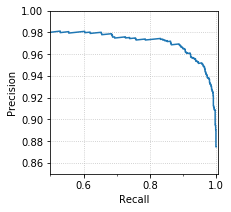

In [266]:
import matplotlib.ticker as ticker

precision, recall, thresh = precision_recall_curve(valid_label[:, 0] == 1, predict_y[:, 0])

plt.figure(figsize=(3, 3))

plt.plot(recall, precision)

plt.xlim([0.5, 1.005])
plt.ylim([0.85, 1.00])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(ls=':', color='silver')
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.savefig('plots/precision_recall.pdf', bbox_inches='tight')